# Некоторые приложения выпуклой оптимизации
(основано на примерах к CVXPY, [ссылка](https://www.cvxpy.org/examples/index.html))

In [2]:
import numpy as np
import cvxpy as cvx
print(cvx.installed_solvers())
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'OSQP']


## Удаление шума

- Изображение
- Звук

### Изображение

In [4]:
from PIL import Image

# np.random.seed(1)
# Load image
orig_img = Image.open("./kandinskiy_comp_viii.jpg")
# orig_img = Image.open("./lena_small.jpg")

# Convert to arrays
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape
print(Uorig.shape)

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted
# The Known matrix is initialized randomly
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1

Ucorr = Known * Uorig
corr_img = Image.fromarray(np.uint8(Ucorr))

(425, 640, 3)


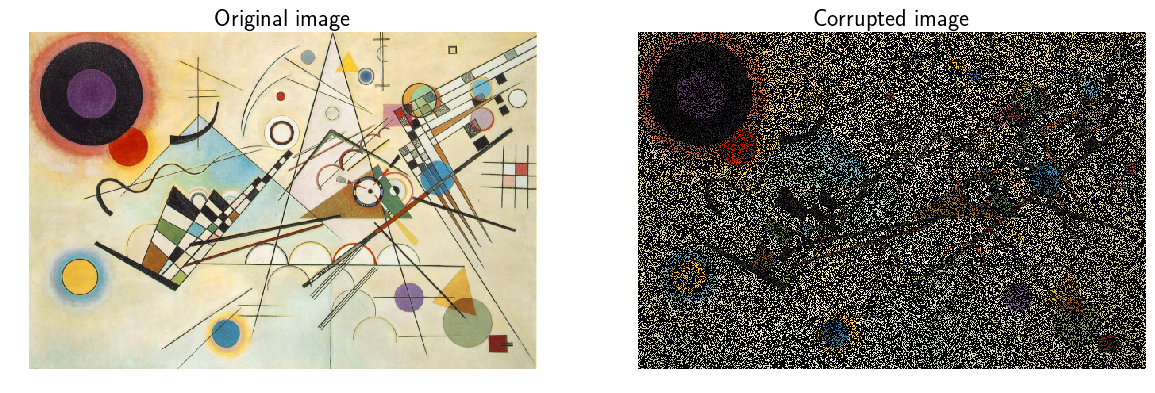

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(orig_img);
ax[0].set_title("Original image", fontsize=24)
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted image", fontsize=24)
ax[1].axis('off');

### Total variation

$$
\begin{align*}
& \min_{X} \sum_{i=1}^{m-1}\sum_{j=1}^{n-1} \left\|\left[ \begin{array}{} 
X_{i+1,j} - X_{ij} \\ X_{i, j+1} - X_{ij}\end{array} \right] \right\|_2\\
\text{s.t. } & X_{ij} = X^{known}_{ij}, \; (i, j) \in \mathcal{I}
\end{align*}
$$

- $\mathcal{I}$ - множество индексов известных значений
- Аппроксимация градиента не в квадрате!

In [6]:
# Define variables and constraints
variables = []
constraints = []
for i in range(colors):
    U = cvx.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(cvx.multiply(Known[:, :, i], U) == cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))

In [7]:
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver="SCS")

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 3767313, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1086936, constraints m = 2712552
Cones:	primal zero / dual free vars: 816000
	soc vars: 1896552, soc blks: 270936
Setup time: 2.79e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.22e+01  1.24e+01  1.00e+00 -4.54e+08  1.96e+07  5.93e-08  3.25e+00 
   100| 2.47e-03  9.86e-04  1.70e-03  4.59e+06  4.61e+06  5.85e-09  6.39e+01 
   180| 8.79e-04  2.35e-04  4.23e-04  4.62e+06  4.62e+06  5.94e-09  1.1

4618526.283227336

In [8]:
# Load variables values into array
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

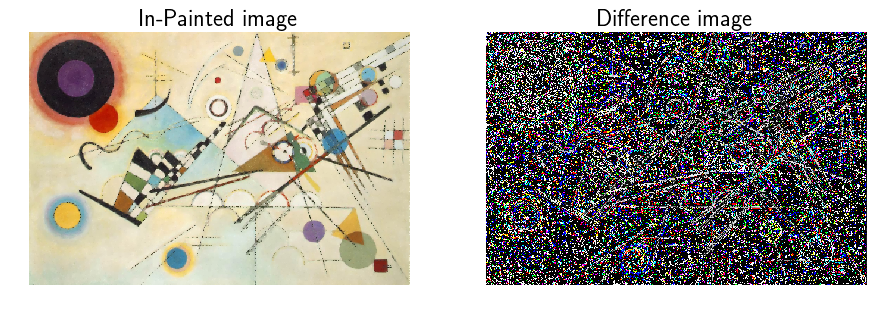

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted image", fontsize=24)
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference image", fontsize=24)
ax[1].axis('off');

### Звук

44100 (7636608,)
500000


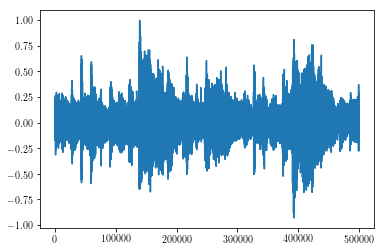

In [19]:
import scipy.io.wavfile as siowav
import IPython.display as ipd

sr, sound = siowav.read("./test_sound.wav")
print(sr, sound.shape)
start = 500000
fin = 1000000

sound = sound[start:fin] / np.max(np.abs(sound[start:fin]))
n = sound.shape[0]
print("Problem dimension = {}".format(n))
plt.plot(sound)
# plt.xscale("log")

In [20]:
ipd.Audio(sound, rate=sr)

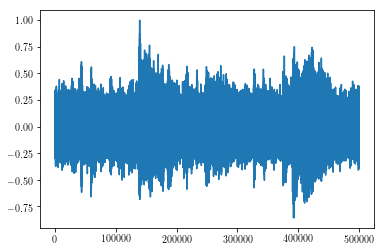

In [21]:
corrupt_sound = sound + 0.1 * np.random.randn(sound.shape[0])
corrupt_sound = corrupt_sound / np.max(np.abs(corrupt_sound))
plt.plot(corrupt_sound)
# plt.xscale("log")

In [22]:
ipd.Audio(corrupt_sound, rate=sr)

#### $\ell_1$ регуляризация

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} |x_i - x_{i+1}|\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [23]:
x_rec = cvx.Variable(corrupt_sound.shape[0])
prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + cvx.tv(x_rec)),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver="SCS", max_iters=500)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4499995, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
Variables n = 1000000, constraints m = 2499999
Cones:	linear vars: 1999998
	soc vars: 500001, soc blks: 1
Setup time: 2.14e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  5.68e-01 
   100| 1.79e-03  2.32e-03  5.53e-02  9.61e+01  1.07e+02  1.08e-10  1.45e+01 
   200| 1.02e-03  1.55e-03  3.49e-02  1.03e+02  1.11e+02  1.08e-10  2.88e+01 
   300| 6.91e-04

104.28730401706026

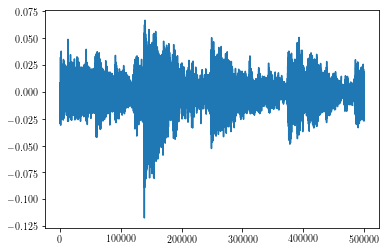

In [29]:
plt.plot(x_rec.value)

In [31]:
ipd.Audio(x_rec.value, rate=sr)

#### $\ell_2$ регуляризация

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} (x_i - x_{i+1})^2\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [32]:
x_rec = cvx.Variable(n)

prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + 
                                cvx.square(cvx.norm(x_rec[1:n] - x_rec[0:n-1]))),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver="SCS", max_iters=500)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2500003, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
Variables n = 500003, constraints m = 2000004
Cones:	linear vars: 1000000
	soc vars: 1000004, soc blks: 3
Setup time: 1.42e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  3.58e-01 
   100| 3.39e-03  2.37e-04  3.44e-02  5.26e+01  5.64e+01  1.57e-13  9.03e+00 
   200| 2.41e-03  1.77e-04  3.27e-02  5.48e+01  5.86e+01  1.74e-13  1.79e+01 
   300| 1.93e-03

58.735202576022616

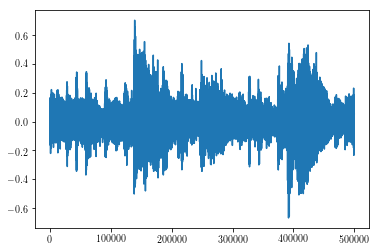

In [33]:
plt.plot(x_rec.value)

In [34]:
ipd.Audio(x_rec.value, rate=sr)

### Выводы

- Различная регуляризация даёт решение с различными свойствами
- Разница между $\ell_1$ и $\ell_2$ регуляризацией
- Способы выбора парамера $\lambda$

## Управление

## Экстремальный эллипсоид

**Задача**: дан набор точек на плоскости $x_i \in \mathbb{R}^2$, необходимо найти эллипс минимальной площади, такой что все точки $x_i$ лежат внутри него. 

**Приложения**

- Телекоммуникаци
- Оценка ковариационной матрицы

**Параметры**: эллипс можно задать аффинным преобразованием

$$
\{x \; | \; \| x \|^2_2 \leq 1\} \to \{ u \;| \; \|u\|^2_2 \leq 1, \; u = Ax + b\}
$$

Тогда площадь увеличивается в $\det (A^{-1})$ раз. 

- Детерминант не является выпуклой/вогнутой функцией
- $\log\det(A^{-1}) = -\log\det(A)$ - выпуклая функция при $A \in \mathbb{S}^n_{++}$

### Задача минимизации

$$
\begin{align*}
& \min_{A, b} -\log\det(A)\\
\text{s.t. } & \|Ax_i + b\| \leq 1\\
& A \succ 0
\end{align*}
$$

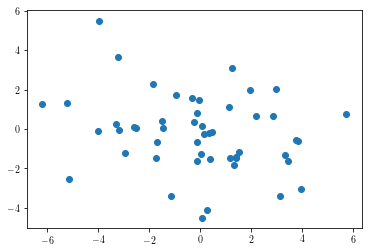

In [193]:
num_points = 50
n = 2
X = 2 * np.random.randn(n, num_points)
plt.scatter(X[0, :], X[1, :])

In [194]:
A = cvx.Variable((n,n), PSD=True)
b = cvx.Variable((n,))
prob = cvx.Problem(cvx.Minimize(-cvx.log_det(A)), 
                   [cvx.norm(A * X[:, i] + b) <= 1 for i in range(num_points)])

In [195]:
prob.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 447, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 73, constraints m = 237
Cones:	primal zero / dual free vars: 15
	linear vars: 50
	soc vars: 150, soc blks: 50
	sd vars: 16, sd blks: 3
	exp vars: 6, dual exp vars: 0
Setup time: 9.50e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.03e+00  1.75e+00  9.19e-01 -8.57e+00  2.76e+00  5.86e-15  1.34e-03 
   100| 2.62e-02  1.02e-02  2.96e-03  3.28e+00  3.30e+00  1.24e-15  3.99e-03 
   200| 6.82e-03  4.61e

3.5058933692589056

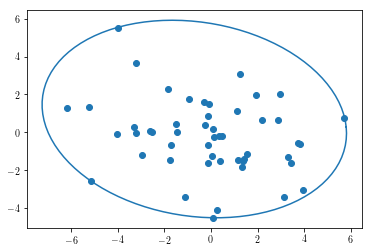

In [196]:
L = np.linalg.inv(A.value)
plt.scatter(X[0, :], X[1, :])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi) - b.value[0], np.sin(phi) - b.value[1]))
ellips = L.dot(xy)
plt.plot(ellips[0, :], ellips[1, :])

## Метод опорных векторов (SVM)

- Дана выборка $(X, y)$, где $X \in \mathbb{R}^{m \times n}$ и $y_i \in \{ +1, -1\}$
- Необходимо построить линейный классификатор вида $\hat{y}_i = \mathrm{sgn}(w^{\top}x_i + b)$, где $w \in \mathbb{R}^n$ и $b \in \mathbb{R}$
- Параметры $w$ и $b$ найдём с помощью следующей задачи оптимизации

$$
\min_{w, b} \frac{1}{m} \sum_{i=1}^m \max(0, 1 - y_i(w^{\top}x_i + b)) + \gamma \|w\|_{*}
$$

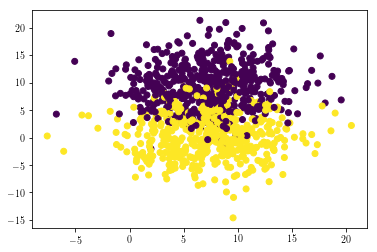

In [112]:
import sklearn.datasets as skldata
import sklearn.model_selection as skms

np.random.seed(8)
n = 2
m = 2000
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4)
y = 2 * y - 1
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
m_train = m // 2
m_test = m_train

In [123]:
beta = cvx.Variable(n)
v = cvx.Variable()
loss = cvx.sum(cvx.pos(1 - cvx.multiply(y_train, X_train*beta + v)))
reg = cvx.norm(beta, 2)
lambd = cvx.Parameter(nonneg=True, value=1)
prob = cvx.Problem(cvx.Minimize(loss / m_train + lambd * reg))
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.464e-02  +4.993e+02  +4e+03  8e-01  9e+00  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +5.030e+02  +1.474e+04  +1e+03  2e+01  8e+02  2e+02  5e-01  0.7543  5e-02   1  1  1 |  0  0
 2  +2.581e+02  +5.319e+03  +8e+02  6e+00  4e+02  8e-01  4e-01  0.2965  4e-02   1  1  1 |  0  0
 3  +1.618e+01  +5.792e+02  +5e+02  6e-01  6e+01  3e+01  2e-01  0.5494  3e-01   1  1  1 |  0  0
 4  +1.339e+01  +1.409e+02  +2e+02  1e-01  3e+01  2e-01  9e-02  0.6793  7e-02   2  1  1 |  0  0
 5  +3.379e+00  +2.125e+01  +1e+02  2e-02  3e+00  4e-01  6e-02  0.5781  5e-01   1  1  1 |  0  0
 6  +1.385e+00  +3.447e+00  +3e+01  2e-03  2e-01  1e-02  2e-02  0.7952  9e-02   1  1  1 |  0  0
 7  +8.774e-01  +1.759e+00  +3e+01  7e-04  6e-02  8e-03  1e-02  0.4331  5e-01   1  1  1 |  0  0
 8  +6.065e-01  +7.095e-01  +6e+00  6e-05  4e-

0.5676182480511398

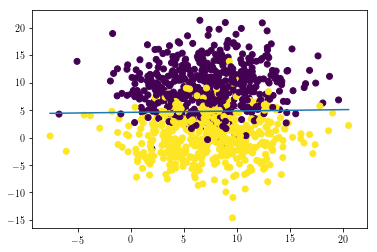

In [124]:
x = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]))
plt.plot(x, (-v.value - beta.value[0] * x) / beta.value[1])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Зависимость от $\lambda$

In [224]:
import sklearn.datasets as skdata 

X, y = skdata.load_breast_cancer(return_X_y=True)
y = 2 * y - 1
print("Data shape = {}".format(X.shape))
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.3)
m_train, n = X_train.shape
m_test = X_test.shape[0]
# Redefine the problem
beta = cvx.Variable(n)
v = cvx.Variable()
loss = cvx.sum(cvx.pos(1 - cvx.multiply(y_train, X_train*beta + v)))
reg = cvx.norm(beta, 2)
lambd = cvx.Parameter(nonneg=True)
prob = cvx.Problem(cvx.Minimize(loss / m_train + lambd * reg))

Data shape = (569, 30)


In [225]:
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-4, -2, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(solver="ECOS")
    train_error[i] = (y_train != np.sign(X_train.dot(beta.value) + v.value)).sum() / m_train
    test_error[i] = (y_test != np.sign(X_test.dot(beta.value) + v.value)).sum() / m_test
    beta_vals.append(beta.value)

Text(0.5,0,'$\\lambda$')

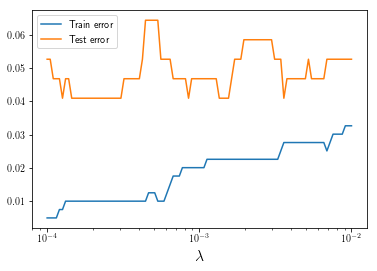

In [226]:
plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)

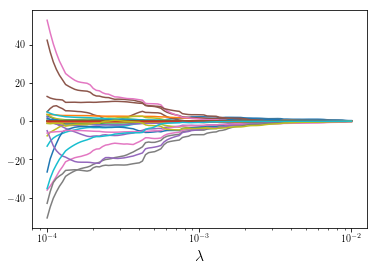

In [227]:
for i in range(n):
    plt.plot(lambda_vals, [wi[i] for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

## Что осталось за кадром

- Портфельная теория Марковица
- Поиск равновесия в транспортных сетях
- Регрессия
- Задачи из биологии
- Релаксации комбинаторных задач
- Распределение энергии в сетях
- Составление расписания потребления мощности
- Задачи из статистики
- Инженерные задачи про формирование массива антенн, про распределение нагрузок в механической конструкции, etc